## GPS Velocity Data Visualization

Load and visualize GPS velocity measurements from North America. The data includes:
- **Longitude, Latitude**: Station positions
- **Ve, Vn**: East and North velocity components (mm/yr)
- **Se, Sn**: Standard deviations of velocity components
- **Profile Line**: From (35.358072°N, -121.212376°W) to (36.666057°N, -118.279928°W)

## Log-Decay MCMC Example

### Overview
This example implements a Bayesian inversion for a **log-decay model** using the Metropolis-Hastings Monte Carlo Markov Chain (MCMC) algorithm. The goal is to estimate model parameters from noisy observations.

### The Forward Model
The physical model describes a logarithmic decay process:
$$d = a \log\left(1 + \frac{t}{t_R}\right)$$

where:
- $d$ = observed data (response)
- $t$ = time (independent variable)
- $a$ = amplitude parameter (unknown)
- $t_R$ = relaxation time parameter (unknown)

### Problem Setup
1. **Synthetic Data Generation**: We create synthetic observations by:
   - Evaluating the forward model with true parameters ($a=1$, $t_R=1$)
   - Adding Gaussian noise with standard deviation $\sigma = 0.15$

2. **Inverse Problem**: Given the noisy observations $d$, estimate the unknown parameters $(a, t_R)$

### Bayesian Approach with MCMC

**Likelihood Function**: Assuming Gaussian errors, the log-likelihood is:
$$\log p(d|a,t_R) = -\frac{1}{2}\sum_{i=1}^{N} \left(\frac{d_i - \hat{d}_i}{\sigma}\right)^2$$

**Prior Distribution** (optional): A Gaussian prior can be included:
$$\log p(a,t_R) = -\frac{1}{2}\sum_{j=1}^{2} \left(\frac{X_j - \mu_j}{\sigma_j}\right)^2$$

where $X = [a, t_R]$, $\mu$ is the prior mean, and $\sigma$ is the prior standard deviation.

**Posterior Distribution** (via Bayes' theorem):
$$p(a,t_R|d) \propto p(d|a,t_R) \cdot p(a,t_R)$$

### Metropolis-Hastings Algorithm
The code uses the Metropolis algorithm to sample from the posterior distribution:

1. Start with an initial guess for parameters
2. **Propose** a new parameter set by taking a random step
3. **Evaluate** the log probability (likelihood + prior) of the proposed parameters
4. **Accept/Reject** using the Metropolis criterion:
   - If $p_{new} > p_{old}$: always accept
   - If $p_{new} < p_{old}$: accept with probability $\exp(p_{new} - p_{old})$
5. Repeat for many iterations to build up a sample distribution

### What the Script Does

1. **Data Generation**: Creates synthetic noisy data from the log-decay model
2. **MCMC Sampling**: Runs 10,000 Metropolis iterations to sample the posterior
3. **Diagnostics**: 
   - Plots log probability evolution (should stabilize after burn-in)
   - Plots parameter traces (should mix well)
4. **Comparison**: Compares MCMC results with grid search method
5. **Results**: 
   - Shows marginal posterior distributions for each parameter
   - Overlays MCMC samples on the likelihood surface
   - Displays model fits to the data
   - Shows prior mean (if prior is enabled)

### Key Parameters to Adjust

- `include_prior`: Set to `True` to use Gaussian prior, `False` for uniform prior
- `prior_m`: Mean values for the prior distribution $[a_{mean}, t_{R,mean}]$
- `prior_sigma`: Standard deviations for the prior $[\sigma_a, \sigma_{t_R}]$
- `stepsize`: Controls the step size in the random walk (affects acceptance rate)
- `NumSamples`: Number of MCMC iterations

### Expected Results

With the prior enabled, the posterior distribution will be shifted toward the prior mean, demonstrating how prior information influences the parameter estimates. The marginal distributions show the uncertainty in each parameter given the data and prior.

Acceptance rate: 0.3018
Prior included: False


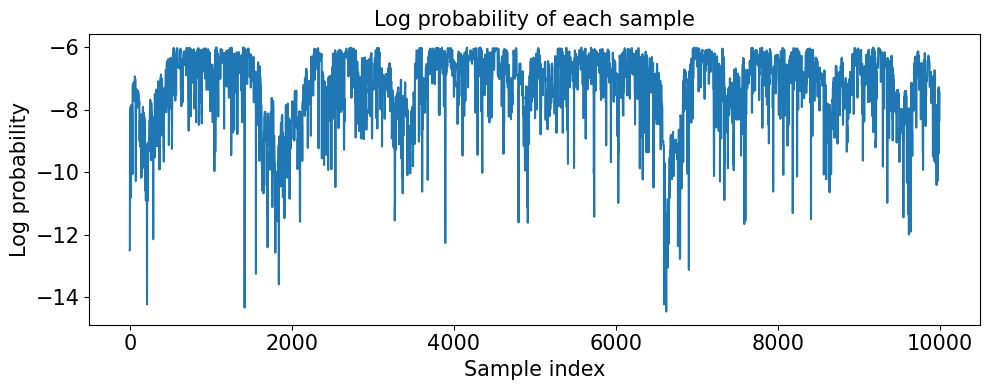

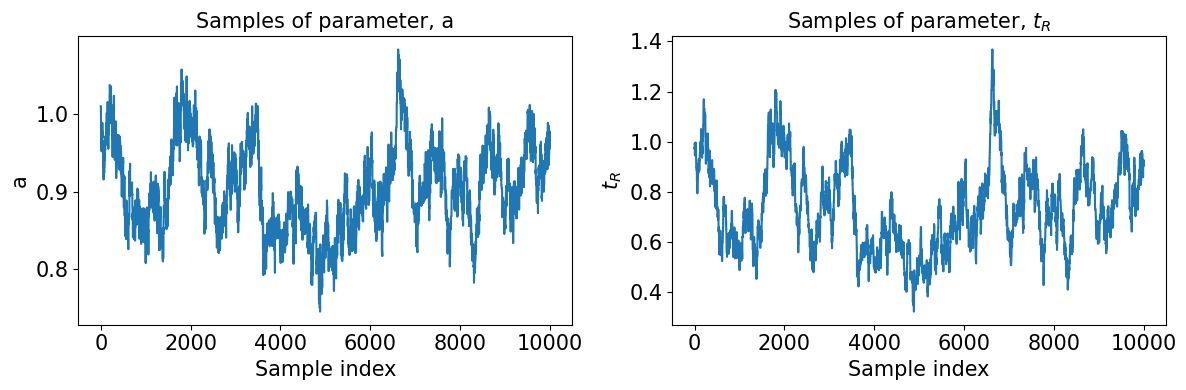

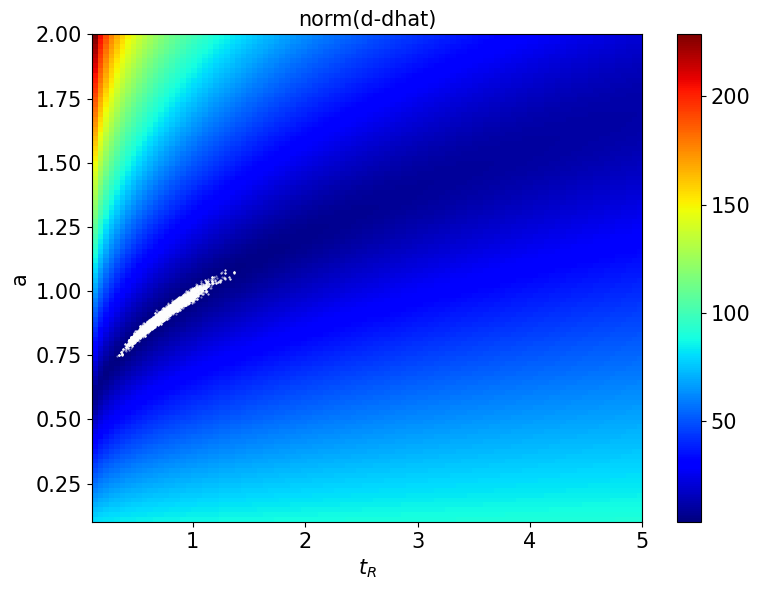

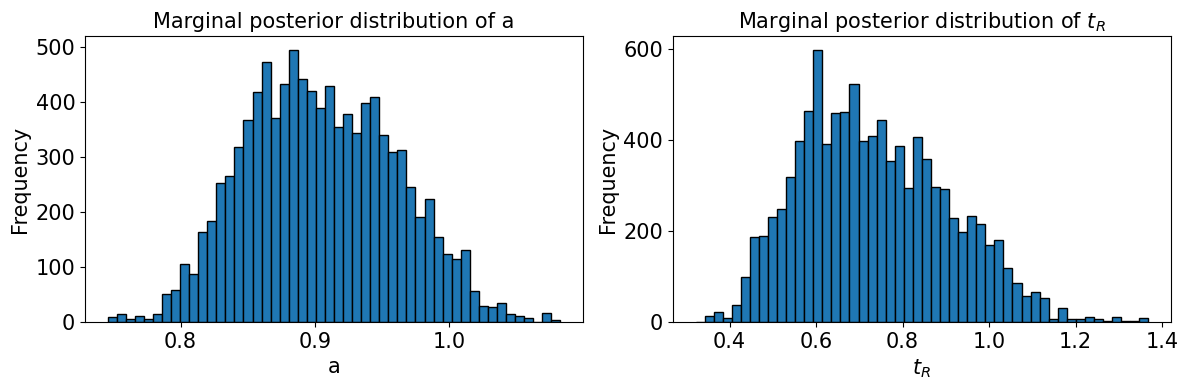

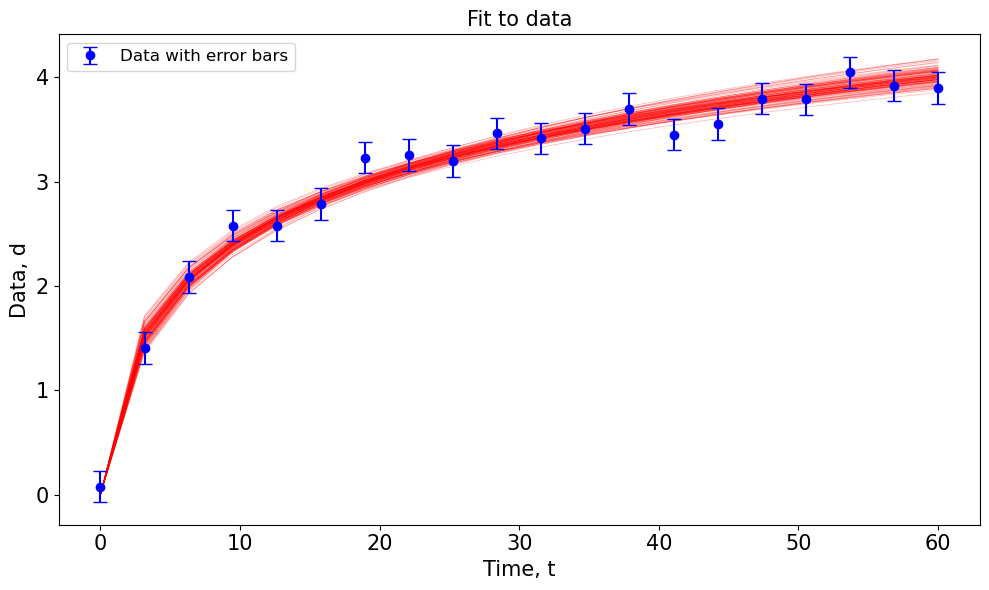

In [3]:
# Log-Decay MCMC Implementation (ported from MATLAB)
import numpy as np
import matplotlib.pyplot as plt

# Metropolis acceptance function
def metropolis(g1, g2):
    """
    Metropolis acceptance criterion
    g1: log probability of current sample
    g2: log probability of proposed sample
    """
    rat = np.exp(g2 - g1)
    if rat > 1:
        accept = 1
    else:
        r = np.random.rand()
        if r < rat:
            accept = 1
        else:
            accept = 0
    return accept


# Make synthetic data assuming d = a*log(1+t/tR)
# where tR is relaxation time and t is time
a = 1
tR = 1

t = np.linspace(0, 60, 20)
d = a * np.log(1 + t/tR)

# Add Gaussian noise
np.random.seed(42)  # for reproducibility
d = d + 0.15 * np.random.randn(len(d))

# Error vector
sigma = 0.15 * np.ones(len(d))

# Initial guess
a = 1
tR = 1
X = np.array([a, tR])

# Number of MC samples
NumSamples = int(1e4)
# Step sizes for Metropolis random walk
stepsize = np.array([0.05, 0.05])

# Include Gaussian prior
include_prior = False
prior_m = np.array([1.4, 2.5])  # prior mean for a, tR
prior_sigma = np.array([0.1, 0.1])  # prior standard deviation for a, tR

# Begin Monte Carlo Metropolis walk
M = np.zeros((len(X), NumSamples))  # store up samples
logprobs = np.zeros(NumSamples)
dhats = np.zeros((len(d), NumSamples))  # store up all dhat

accept_sample = 0  # keep track of acceptance rate

for k in range(NumSamples):
    # Take a random step in model space to select trial value
    r = (-1)**np.round(np.random.rand(len(X))) * np.random.rand(len(X))  # rand (-1,1)
    r = r * stepsize
    X = X + r  # trial value (X prime)
    
    a = X[0]
    tR = X[1]
    dhat2 = a * np.log(1 + t/tR)
    resid = (d - dhat2) / sigma  # weighted residual vector
    
    # Compute log probability of trial sample
    if include_prior:
        logprior = -0.5 * np.dot((X - prior_m) / prior_sigma, (X - prior_m) / prior_sigma)
        logprob2 = -0.5 * np.dot(resid, resid) + logprior  # assumes Gaussian likelihood
    else:
        logprob2 = -0.5 * np.dot(resid, resid)
    
    # Use Metropolis rule to decide whether or not to accept model
    if k == 0:
        logprob = logprob2
        dhat = dhat2
    
    accept = metropolis(logprob, logprob2)
    
    if accept == 1:  # if accept==1, keep the model
        logprob = logprob2
        dhat = dhat2
        Xprev = X.copy()
        logprobprev = logprob
        accept_sample = accept_sample + 1
    else:  # if accept==0, discard this model and retain previous
        X = Xprev.copy()
        logprob = logprobprev
    
    # Store results matrices
    M[:, k] = X
    
    # Store values
    logprobs[k] = logprob
    dhats[:, k] = dhat

acceptance_rate = accept_sample / NumSamples
print(f'Acceptance rate: {acceptance_rate:.4f}')
print(f'Prior included: {include_prior}')
if include_prior:
    print(f'Prior mean: a={prior_m[0]}, tR={prior_m[1]}')
    print(f'Prior std: a={prior_sigma[0]}, tR={prior_sigma[1]}')

# Evaluate quality of sampling
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(logprobs)
ax.set_title('Log probability of each sample', fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xlabel('Sample index', fontsize=15)
ax.set_ylabel('Log probability', fontsize=15)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(M[0, :])
ax1.set_title('Samples of parameter, a', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Sample index', fontsize=15)
ax1.set_ylabel('a', fontsize=15)

ax2.plot(M[1, :])
ax2.set_title('Samples of parameter, $t_R$', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Sample index', fontsize=15)
ax2.set_ylabel('$t_R$', fontsize=15)
plt.tight_layout()
plt.show()

# Now compare with gridsearch method
# Define range of parameters to search
as_grid = np.linspace(0.1, 2, 100)
tRs_grid = np.linspace(0.1, 5, 100)

residual = np.zeros((len(as_grid), len(tRs_grid)))

for loop1 in range(len(as_grid)):
    for loop2 in range(len(tRs_grid)):
        dhat = as_grid[loop1] * np.log(1 + t/tRs_grid[loop2])
        residual[loop1, loop2] = np.linalg.norm(d/sigma - dhat/sigma)

# Plot (weighted) residual
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(residual, extent=[tRs_grid[0], tRs_grid[-1], as_grid[0], as_grid[-1]], 
               aspect='auto', origin='lower', cmap='jet')
ax.set_xlabel('$t_R$', fontsize=15)
ax.set_ylabel('a', fontsize=15)
ax.set_title('norm(d-dhat)', fontsize=15)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=15)
ax.tick_params(labelsize=15)

# Plot bootstrap samples on grid search
ax.plot(M[1, :], M[0, :], 'w.', markersize=1, alpha=0.5)

# If prior is included, plot prior mean as a marker
if include_prior:
    ax.plot(prior_m[1], prior_m[0], 'r*', markersize=20, label='Prior mean', markeredgecolor='white', markeredgewidth=1)
    ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Plot marginal distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(M[0, :], bins=50, edgecolor='black')
ax1.set_title('Marginal posterior distribution of a', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('a', fontsize=15)
ax1.set_ylabel('Frequency', fontsize=15)
if include_prior:
    ax1.axvline(prior_m[0], color='r', linestyle='--', linewidth=2, label='Prior mean')
    ax1.legend(fontsize=12)

ax2.hist(M[1, :], bins=50, edgecolor='black')
ax2.set_title('Marginal posterior distribution of $t_R$', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('$t_R$', fontsize=15)
ax2.set_ylabel('Frequency', fontsize=15)
if include_prior:
    ax2.axvline(prior_m[1], color='r', linestyle='--', linewidth=2, label='Prior mean')
    ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Plot fit to data
fig, ax = plt.subplots(figsize=(10, 6))
# Plot subset of fits (every 100th sample)
ax.plot(t, dhats[:, ::100], 'r', alpha=0.3, linewidth=0.5)
ax.errorbar(t, d, yerr=sigma, fmt='bo', capsize=5, label='Data with error bars')
ax.tick_params(labelsize=15)
ax.set_title('Fit to data', fontsize=15)
ax.set_xlabel('Time, t', fontsize=15)
ax.set_ylabel('Data, d', fontsize=15)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()